# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 26988 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=2)


  0% (    1 of 26988) |            | Elapsed Time: 0:00:05 ETA:  1 day, 16:44:13

  0% (   24 of 26988) |                    | Elapsed Time: 0:00:06 ETA:  0:19:29

  0% (   94 of 26988) |                    | Elapsed Time: 0:00:07 ETA:  0:09:35

  0% (  169 of 26988) |                    | Elapsed Time: 0:00:08 ETA:  0:07:58

  0% (  229 of 26988) |                    | Elapsed Time: 0:00:09 ETA:  0:07:56

  1% (  308 of 26988) |                    | Elapsed Time: 0:00:10 ETA:  0:07:19

  1% (  338 of 26988) |                    | Elapsed Time: 0:00:10 ETA:  0:07:11

  1% (  372 of 26988) |                    | Elapsed Time: 0:00:11 ETA:  0:07:44

  1% (  414 of 26988) |                    | Elapsed Time: 0:00:13 ETA:  0:08:08

  1% (  422 of 26988) |                    | Elapsed Time: 0:00:14 ETA:  0:09:02

  1% (  481 of 26988) |                    | Elapsed Time: 0:00:15 ETA:  0:08:21

  1% (  524 of 26988) |                    | Elapsed Time: 0:00:16 ETA:  0:08:54

  2% (  554 of 26988) |                    | Elapsed Time: 0:00:17 ETA:  0:09:58

  2% (  612 of 26988) |                    | Elapsed Time: 0:00:18 ETA:  0:09:56

  2% (  662 of 26988) |                    | Elapsed Time: 0:00:19 ETA:  0:10:46

  2% (  675 of 26988) |                    | Elapsed Time: 0:00:19 ETA:  0:11:08

  2% (  723 of 26988) |                    | Elapsed Time: 0:00:20 ETA:  0:10:38

  2% (  789 of 26988) |                    | Elapsed Time: 0:00:21 ETA:  0:09:47

  3% (  844 of 26988) |                    | Elapsed Time: 0:00:22 ETA:  0:08:41

  3% (  906 of 26988) |                    | Elapsed Time: 0:00:23 ETA:  0:08:32

  3% (  963 of 26988) |                    | Elapsed Time: 0:00:24 ETA:  0:08:13

  3% ( 1013 of 26988) |                    | Elapsed Time: 0:00:25 ETA:  0:07:45

  4% ( 1091 of 26988) |                    | Elapsed Time: 0:00:26 ETA:  0:07:23

  4% ( 1181 of 26988) |                    | Elapsed Time: 0:00:27 ETA:  0:06:45

  4% ( 1252 of 26988) |                    | Elapsed Time: 0:00:28 ETA:  0:06:35

  5% ( 1350 of 26988) |#                   | Elapsed Time: 0:00:29 ETA:  0:06:01

  5% ( 1442 of 26988) |#                   | Elapsed Time: 0:00:30 ETA:  0:05:34

  5% ( 1532 of 26988) |#                   | Elapsed Time: 0:00:31 ETA:  0:05:17

  6% ( 1623 of 26988) |#                   | Elapsed Time: 0:00:32 ETA:  0:04:58

  6% ( 1687 of 26988) |#                   | Elapsed Time: 0:00:33 ETA:  0:04:47

  6% ( 1764 of 26988) |#                   | Elapsed Time: 0:00:34 ETA:  0:04:46

  6% ( 1839 of 26988) |#                   | Elapsed Time: 0:00:35 ETA:  0:04:53

  7% ( 1915 of 26988) |#                   | Elapsed Time: 0:00:36 ETA:  0:04:49

  7% ( 1991 of 26988) |#                   | Elapsed Time: 0:00:37 ETA:  0:04:55

  7% ( 2025 of 26988) |#                   | Elapsed Time: 0:00:38 ETA:  0:04:56

  7% ( 2104 of 26988) |#                   | Elapsed Time: 0:00:39 ETA:  0:05:01

  8% ( 2182 of 26988) |#                   | Elapsed Time: 0:00:40 ETA:  0:05:06

  8% ( 2258 of 26988) |#                   | Elapsed Time: 0:00:41 ETA:  0:05:13

  8% ( 2336 of 26988) |#                   | Elapsed Time: 0:00:42 ETA:  0:05:10

  8% ( 2362 of 26988) |#                   | Elapsed Time: 0:00:42 ETA:  0:05:10

  8% ( 2428 of 26988) |#                   | Elapsed Time: 0:00:43 ETA:  0:05:14

  9% ( 2519 of 26988) |#                   | Elapsed Time: 0:00:44 ETA:  0:05:04

  9% ( 2609 of 26988) |#                   | Elapsed Time: 0:00:45 ETA:  0:04:55

  9% ( 2683 of 26988) |#                   | Elapsed Time: 0:00:46 ETA:  0:04:56

 10% ( 2699 of 26988) |##                  | Elapsed Time: 0:00:46 ETA:  0:05:05

 10% ( 2768 of 26988) |##                  | Elapsed Time: 0:00:47 ETA:  0:05:09

 10% ( 2843 of 26988) |##                  | Elapsed Time: 0:00:48 ETA:  0:05:09

 10% ( 2924 of 26988) |##                  | Elapsed Time: 0:00:49 ETA:  0:05:06

 11% ( 3006 of 26988) |##                  | Elapsed Time: 0:00:50 ETA:  0:05:02

 11% ( 3037 of 26988) |##                  | Elapsed Time: 0:00:51 ETA:  0:04:55

 11% ( 3102 of 26988) |##                  | Elapsed Time: 0:00:52 ETA:  0:05:13

 11% ( 3143 of 26988) |##                  | Elapsed Time: 0:00:53 ETA:  0:05:46

 11% ( 3205 of 26988) |##                  | Elapsed Time: 0:00:54 ETA:  0:05:54

 12% ( 3290 of 26988) |##                  | Elapsed Time: 0:00:55 ETA:  0:05:33

 12% ( 3342 of 26988) |##                  | Elapsed Time: 0:00:56 ETA:  0:05:43

 12% ( 3374 of 26988) |##                  | Elapsed Time: 0:00:56 ETA:  0:05:45

 12% ( 3448 of 26988) |##                  | Elapsed Time: 0:00:57 ETA:  0:05:50

 13% ( 3518 of 26988) |##                  | Elapsed Time: 0:00:58 ETA:  0:05:59

 13% ( 3576 of 26988) |##                  | Elapsed Time: 0:00:59 ETA:  0:06:08

 13% ( 3666 of 26988) |##                  | Elapsed Time: 0:01:00 ETA:  0:05:45

 13% ( 3711 of 26988) |##                  | Elapsed Time: 0:01:01 ETA:  0:05:17

 13% ( 3763 of 26988) |##                  | Elapsed Time: 0:01:02 ETA:  0:05:24

 14% ( 3813 of 26988) |##                  | Elapsed Time: 0:01:03 ETA:  0:05:49

 14% ( 3868 of 26988) |##                  | Elapsed Time: 0:01:04 ETA:  0:05:46

 14% ( 3956 of 26988) |##                  | Elapsed Time: 0:01:05 ETA:  0:05:33

 15% ( 4049 of 26988) |###                 | Elapsed Time: 0:01:06 ETA:  0:05:23

 15% ( 4131 of 26988) |###                 | Elapsed Time: 0:01:07 ETA:  0:05:05

 15% ( 4227 of 26988) |###                 | Elapsed Time: 0:01:08 ETA:  0:05:00

 15% ( 4295 of 26988) |###                 | Elapsed Time: 0:01:09 ETA:  0:05:08

 16% ( 4386 of 26988) |###                 | Elapsed Time: 0:01:10 ETA:  0:04:36

 16% ( 4452 of 26988) |###                 | Elapsed Time: 0:01:11 ETA:  0:04:28

 16% ( 4541 of 26988) |###                 | Elapsed Time: 0:01:12 ETA:  0:04:27

 17% ( 4625 of 26988) |###                 | Elapsed Time: 0:01:13 ETA:  0:04:28

 17% ( 4709 of 26988) |###                 | Elapsed Time: 0:01:14 ETA:  0:04:24

 17% ( 4723 of 26988) |###                 | Elapsed Time: 0:01:14 ETA:  0:04:26

 17% ( 4802 of 26988) |###                 | Elapsed Time: 0:01:15 ETA:  0:04:35

 18% ( 4879 of 26988) |###                 | Elapsed Time: 0:01:16 ETA:  0:04:29

 18% ( 4956 of 26988) |###                 | Elapsed Time: 0:01:17 ETA:  0:04:25

 18% ( 5036 of 26988) |###                 | Elapsed Time: 0:01:18 ETA:  0:04:24

 18% ( 5061 of 26988) |###                 | Elapsed Time: 0:01:19 ETA:  0:04:19

 18% ( 5113 of 26988) |###                 | Elapsed Time: 0:01:20 ETA:  0:04:40

 19% ( 5202 of 26988) |###                 | Elapsed Time: 0:01:21 ETA:  0:04:36

 19% ( 5275 of 26988) |###                 | Elapsed Time: 0:01:22 ETA:  0:04:42

 19% ( 5356 of 26988) |###                 | Elapsed Time: 0:01:23 ETA:  0:04:36

 20% ( 5398 of 26988) |####                | Elapsed Time: 0:01:24 ETA:  0:04:52

 20% ( 5463 of 26988) |####                | Elapsed Time: 0:01:25 ETA:  0:04:59

 20% ( 5512 of 26988) |####                | Elapsed Time: 0:01:26 ETA:  0:05:18

 20% ( 5588 of 26988) |####                | Elapsed Time: 0:01:27 ETA:  0:05:21

 20% ( 5632 of 26988) |####                | Elapsed Time: 0:01:28 ETA:  0:05:36

 21% ( 5692 of 26988) |####                | Elapsed Time: 0:01:29 ETA:  0:05:29

 21% ( 5735 of 26988) |####                | Elapsed Time: 0:01:30 ETA:  0:05:51

 21% ( 5809 of 26988) |####                | Elapsed Time: 0:01:31 ETA:  0:05:48

 21% ( 5866 of 26988) |####                | Elapsed Time: 0:01:32 ETA:  0:06:08

 22% ( 5947 of 26988) |####                | Elapsed Time: 0:01:33 ETA:  0:05:40

 22% ( 6033 of 26988) |####                | Elapsed Time: 0:01:34 ETA:  0:05:23

 22% ( 6073 of 26988) |####                | Elapsed Time: 0:01:34 ETA:  0:05:03

 22% ( 6160 of 26988) |####                | Elapsed Time: 0:01:35 ETA:  0:04:53

 23% ( 6245 of 26988) |####                | Elapsed Time: 0:01:36 ETA:  0:04:26

 23% ( 6329 of 26988) |####                | Elapsed Time: 0:01:37 ETA:  0:04:12

 23% ( 6410 of 26988) |####                | Elapsed Time: 0:01:38 ETA:  0:04:02

 24% ( 6483 of 26988) |####                | Elapsed Time: 0:01:39 ETA:  0:03:52

 24% ( 6550 of 26988) |####                | Elapsed Time: 0:01:40 ETA:  0:03:59

 24% ( 6616 of 26988) |####                | Elapsed Time: 0:01:41 ETA:  0:04:10

 24% ( 6719 of 26988) |####                | Elapsed Time: 0:01:42 ETA:  0:03:56

 25% ( 6748 of 26988) |#####               | Elapsed Time: 0:01:43 ETA:  0:04:05

 25% ( 6838 of 26988) |#####               | Elapsed Time: 0:01:44 ETA:  0:04:01

 25% ( 6931 of 26988) |#####               | Elapsed Time: 0:01:45 ETA:  0:03:55

 25% ( 7009 of 26988) |#####               | Elapsed Time: 0:01:46 ETA:  0:03:53

 26% ( 7063 of 26988) |#####               | Elapsed Time: 0:01:47 ETA:  0:04:05

 26% ( 7085 of 26988) |#####               | Elapsed Time: 0:01:47 ETA:  0:04:00

 26% ( 7183 of 26988) |#####               | Elapsed Time: 0:01:48 ETA:  0:03:42

 26% ( 7258 of 26988) |#####               | Elapsed Time: 0:01:49 ETA:  0:03:36

 27% ( 7339 of 26988) |#####               | Elapsed Time: 0:01:50 ETA:  0:03:46

 27% ( 7422 of 26988) |#####               | Elapsed Time: 0:01:51 ETA:  0:03:48

 27% ( 7498 of 26988) |#####               | Elapsed Time: 0:01:52 ETA:  0:03:57

 28% ( 7571 of 26988) |#####               | Elapsed Time: 0:01:53 ETA:  0:03:59

 28% ( 7646 of 26988) |#####               | Elapsed Time: 0:01:54 ETA:  0:03:45

 28% ( 7724 of 26988) |#####               | Elapsed Time: 0:01:55 ETA:  0:03:47

 28% ( 7760 of 26988) |#####               | Elapsed Time: 0:01:56 ETA:  0:03:56

 29% ( 7840 of 26988) |#####               | Elapsed Time: 0:01:57 ETA:  0:03:54

 29% ( 7910 of 26988) |#####               | Elapsed Time: 0:01:58 ETA:  0:04:00

 29% ( 8003 of 26988) |#####               | Elapsed Time: 0:01:59 ETA:  0:03:48

 30% ( 8097 of 26988) |######              | Elapsed Time: 0:02:00 ETA:  0:03:41

 30% ( 8171 of 26988) |######              | Elapsed Time: 0:02:01 ETA:  0:03:39

 30% ( 8241 of 26988) |######              | Elapsed Time: 0:02:02 ETA:  0:03:43

 30% ( 8326 of 26988) |######              | Elapsed Time: 0:02:03 ETA:  0:03:38

 31% ( 8413 of 26988) |######              | Elapsed Time: 0:02:04 ETA:  0:03:35

 31% ( 8434 of 26988) |######              | Elapsed Time: 0:02:04 ETA:  0:03:32

 31% ( 8512 of 26988) |######              | Elapsed Time: 0:02:05 ETA:  0:03:45

 31% ( 8598 of 26988) |######              | Elapsed Time: 0:02:06 ETA:  0:03:48

 32% ( 8689 of 26988) |######              | Elapsed Time: 0:02:07 ETA:  0:03:44

 32% ( 8772 of 26988) |######              | Elapsed Time: 0:02:08 ETA:  0:03:40

 32% ( 8866 of 26988) |######              | Elapsed Time: 0:02:09 ETA:  0:03:29

 33% ( 8960 of 26988) |######              | Elapsed Time: 0:02:10 ETA:  0:03:15

 33% ( 9051 of 26988) |######              | Elapsed Time: 0:02:11 ETA:  0:03:13

 33% ( 9109 of 26988) |######              | Elapsed Time: 0:02:12 ETA:  0:03:16

 34% ( 9193 of 26988) |######              | Elapsed Time: 0:02:13 ETA:  0:03:15

 34% ( 9291 of 26988) |######              | Elapsed Time: 0:02:14 ETA:  0:02:51

 34% ( 9390 of 26988) |######              | Elapsed Time: 0:02:15 ETA:  0:02:45

 35% ( 9446 of 26988) |#######             | Elapsed Time: 0:02:16 ETA:  0:02:43

 35% ( 9535 of 26988) |#######             | Elapsed Time: 0:02:17 ETA:  0:02:40

 35% ( 9605 of 26988) |#######             | Elapsed Time: 0:02:18 ETA:  0:02:49

 35% ( 9699 of 26988) |#######             | Elapsed Time: 0:02:19 ETA:  0:02:48

 36% ( 9784 of 26988) |#######             | Elapsed Time: 0:02:20 ETA:  0:02:47

 36% ( 9859 of 26988) |#######             | Elapsed Time: 0:02:21 ETA:  0:02:47

 36% ( 9941 of 26988) |#######             | Elapsed Time: 0:02:22 ETA:  0:02:47

 37% (10013 of 26988) |#######             | Elapsed Time: 0:02:23 ETA:  0:02:57

 37% (10092 of 26988) |#######             | Elapsed Time: 0:02:24 ETA:  0:03:05

 37% (10121 of 26988) |#######             | Elapsed Time: 0:02:24 ETA:  0:03:09

 37% (10210 of 26988) |#######             | Elapsed Time: 0:02:25 ETA:  0:03:08

 38% (10302 of 26988) |#######             | Elapsed Time: 0:02:26 ETA:  0:02:56

 38% (10391 of 26988) |#######             | Elapsed Time: 0:02:27 ETA:  0:02:58

 38% (10458 of 26988) |#######             | Elapsed Time: 0:02:28 ETA:  0:03:03

 39% (10542 of 26988) |#######             | Elapsed Time: 0:02:29 ETA:  0:02:57

 39% (10630 of 26988) |#######             | Elapsed Time: 0:02:30 ETA:  0:02:54

 39% (10720 of 26988) |#######             | Elapsed Time: 0:02:31 ETA:  0:02:44

 40% (10796 of 26988) |########            | Elapsed Time: 0:02:32 ETA:  0:02:42

 40% (10885 of 26988) |########            | Elapsed Time: 0:02:33 ETA:  0:02:40

 40% (10950 of 26988) |########            | Elapsed Time: 0:02:34 ETA:  0:02:50

 40% (11031 of 26988) |########            | Elapsed Time: 0:02:35 ETA:  0:02:53

 41% (11133 of 26988) |########            | Elapsed Time: 0:02:36 ETA:  0:02:48

 41% (11215 of 26988) |########            | Elapsed Time: 0:02:37 ETA:  0:02:48

 41% (11299 of 26988) |########            | Elapsed Time: 0:02:38 ETA:  0:02:49

 42% (11390 of 26988) |########            | Elapsed Time: 0:02:39 ETA:  0:02:48

 42% (11470 of 26988) |########            | Elapsed Time: 0:02:40 ETA:  0:02:52

 42% (11559 of 26988) |########            | Elapsed Time: 0:02:41 ETA:  0:02:37

 43% (11635 of 26988) |########            | Elapsed Time: 0:02:42 ETA:  0:02:39

 43% (11715 of 26988) |########            | Elapsed Time: 0:02:43 ETA:  0:02:43

 43% (11808 of 26988) |########            | Elapsed Time: 0:02:44 ETA:  0:02:42

 44% (11895 of 26988) |########            | Elapsed Time: 0:02:45 ETA:  0:02:40

 44% (11983 of 26988) |########            | Elapsed Time: 0:02:46 ETA:  0:02:40

 44% (12071 of 26988) |########            | Elapsed Time: 0:02:47 ETA:  0:02:34

 45% (12145 of 26988) |#########           | Elapsed Time: 0:02:48 ETA:  0:02:32

 45% (12219 of 26988) |#########           | Elapsed Time: 0:02:49 ETA:  0:02:38

 45% (12281 of 26988) |#########           | Elapsed Time: 0:02:50 ETA:  0:02:44

 45% (12356 of 26988) |#########           | Elapsed Time: 0:02:51 ETA:  0:02:46

 46% (12439 of 26988) |#########           | Elapsed Time: 0:02:52 ETA:  0:02:46

 46% (12482 of 26988) |#########           | Elapsed Time: 0:02:53 ETA:  0:03:13

 46% (12568 of 26988) |#########           | Elapsed Time: 0:02:54 ETA:  0:03:14

 46% (12661 of 26988) |#########           | Elapsed Time: 0:02:55 ETA:  0:03:10

 47% (12741 of 26988) |#########           | Elapsed Time: 0:02:56 ETA:  0:03:13

 47% (12820 of 26988) |#########           | Elapsed Time: 0:02:57 ETA:  0:03:07

 47% (12902 of 26988) |#########           | Elapsed Time: 0:02:58 ETA:  0:02:54

 48% (12978 of 26988) |#########           | Elapsed Time: 0:02:59 ETA:  0:02:53

 48% (13058 of 26988) |#########           | Elapsed Time: 0:03:00 ETA:  0:02:53

 48% (13136 of 26988) |#########           | Elapsed Time: 0:03:01 ETA:  0:02:29

 48% (13157 of 26988) |#########           | Elapsed Time: 0:03:02 ETA:  0:02:28

 49% (13239 of 26988) |#########           | Elapsed Time: 0:03:03 ETA:  0:02:29

 49% (13321 of 26988) |#########           | Elapsed Time: 0:03:04 ETA:  0:02:33

 49% (13399 of 26988) |#########           | Elapsed Time: 0:03:05 ETA:  0:02:33

 49% (13474 of 26988) |#########           | Elapsed Time: 0:03:06 ETA:  0:02:35

 50% (13495 of 26988) |##########          | Elapsed Time: 0:03:06 ETA:  0:02:35

 50% (13576 of 26988) |##########          | Elapsed Time: 0:03:07 ETA:  0:02:31

 50% (13667 of 26988) |##########          | Elapsed Time: 0:03:08 ETA:  0:02:24

 50% (13759 of 26988) |##########          | Elapsed Time: 0:03:09 ETA:  0:02:15

 51% (13832 of 26988) |##########          | Elapsed Time: 0:03:10 ETA:  0:02:11

 51% (13917 of 26988) |##########          | Elapsed Time: 0:03:11 ETA:  0:02:09

 51% (13997 of 26988) |##########          | Elapsed Time: 0:03:12 ETA:  0:02:08

 52% (14088 of 26988) |##########          | Elapsed Time: 0:03:13 ETA:  0:02:01

 52% (14169 of 26988) |##########          | Elapsed Time: 0:03:14 ETA:  0:01:58

 52% (14255 of 26988) |##########          | Elapsed Time: 0:03:15 ETA:  0:01:58

 53% (14335 of 26988) |##########          | Elapsed Time: 0:03:16 ETA:  0:01:57

 53% (14434 of 26988) |##########          | Elapsed Time: 0:03:17 ETA:  0:01:53

 53% (14507 of 26988) |##########          | Elapsed Time: 0:03:18 ETA:  0:01:55

 54% (14606 of 26988) |##########          | Elapsed Time: 0:03:19 ETA:  0:01:51

 54% (14694 of 26988) |##########          | Elapsed Time: 0:03:20 ETA:  0:01:49

 54% (14785 of 26988) |##########          | Elapsed Time: 0:03:21 ETA:  0:01:44

 55% (14844 of 26988) |###########         | Elapsed Time: 0:03:21 ETA:  0:01:45

 55% (14933 of 26988) |###########         | Elapsed Time: 0:03:22 ETA:  0:01:41

 55% (15024 of 26988) |###########         | Elapsed Time: 0:03:23 ETA:  0:01:37

 55% (15106 of 26988) |###########         | Elapsed Time: 0:03:24 ETA:  0:01:36

 56% (15181 of 26988) |###########         | Elapsed Time: 0:03:25 ETA:  0:01:43

 56% (15273 of 26988) |###########         | Elapsed Time: 0:03:26 ETA:  0:01:39

 56% (15358 of 26988) |###########         | Elapsed Time: 0:03:27 ETA:  0:01:44

 57% (15439 of 26988) |###########         | Elapsed Time: 0:03:28 ETA:  0:01:46

 57% (15519 of 26988) |###########         | Elapsed Time: 0:03:29 ETA:  0:01:46

 57% (15602 of 26988) |###########         | Elapsed Time: 0:03:30 ETA:  0:01:46

 58% (15697 of 26988) |###########         | Elapsed Time: 0:03:31 ETA:  0:01:42

 58% (15772 of 26988) |###########         | Elapsed Time: 0:03:32 ETA:  0:01:48

 58% (15856 of 26988) |###########         | Elapsed Time: 0:03:33 ETA:  0:01:47

 59% (15938 of 26988) |###########         | Elapsed Time: 0:03:34 ETA:  0:01:50

 59% (16018 of 26988) |###########         | Elapsed Time: 0:03:35 ETA:  0:01:52

 59% (16101 of 26988) |###########         | Elapsed Time: 0:03:36 ETA:  0:01:50

 60% (16193 of 26988) |############        | Elapsed Time: 0:03:37 ETA:  0:01:50

 60% (16267 of 26988) |############        | Elapsed Time: 0:03:39 ETA:  0:02:02

 60% (16344 of 26988) |############        | Elapsed Time: 0:03:40 ETA:  0:01:59

 60% (16423 of 26988) |############        | Elapsed Time: 0:03:41 ETA:  0:01:58

 61% (16504 of 26988) |############        | Elapsed Time: 0:03:42 ETA:  0:01:56

 61% (16531 of 26988) |############        | Elapsed Time: 0:03:42 ETA:  0:01:57

 61% (16613 of 26988) |############        | Elapsed Time: 0:03:43 ETA:  0:01:54

 61% (16691 of 26988) |############        | Elapsed Time: 0:03:44 ETA:  0:01:56

 62% (16776 of 26988) |############        | Elapsed Time: 0:03:45 ETA:  0:01:56

 62% (16868 of 26988) |############        | Elapsed Time: 0:03:46 ETA:  0:01:50

 62% (16941 of 26988) |############        | Elapsed Time: 0:03:47 ETA:  0:01:51

 63% (17031 of 26988) |############        | Elapsed Time: 0:03:48 ETA:  0:01:45

 63% (17135 of 26988) |############        | Elapsed Time: 0:03:49 ETA:  0:01:31

 63% (17205 of 26988) |############        | Elapsed Time: 0:03:51 ETA:  0:02:02

 64% (17284 of 26988) |############        | Elapsed Time: 0:03:52 ETA:  0:02:01

 64% (17362 of 26988) |############        | Elapsed Time: 0:03:53 ETA:  0:02:04

 64% (17460 of 26988) |############        | Elapsed Time: 0:03:54 ETA:  0:01:54

 65% (17543 of 26988) |#############       | Elapsed Time: 0:03:55 ETA:  0:01:48

 65% (17624 of 26988) |#############       | Elapsed Time: 0:03:56 ETA:  0:01:43

 65% (17708 of 26988) |#############       | Elapsed Time: 0:03:57 ETA:  0:01:45

 65% (17791 of 26988) |#############       | Elapsed Time: 0:03:58 ETA:  0:01:55

 66% (17880 of 26988) |#############       | Elapsed Time: 0:03:59 ETA:  0:01:22

 66% (17969 of 26988) |#############       | Elapsed Time: 0:04:00 ETA:  0:01:16

 66% (18058 of 26988) |#############       | Elapsed Time: 0:04:01 ETA:  0:01:10

 67% (18145 of 26988) |#############       | Elapsed Time: 0:04:02 ETA:  0:01:14

 67% (18217 of 26988) |#############       | Elapsed Time: 0:04:02 ETA:  0:01:12

 67% (18305 of 26988) |#############       | Elapsed Time: 0:04:03 ETA:  0:01:07

 68% (18390 of 26988) |#############       | Elapsed Time: 0:04:04 ETA:  0:01:06

 68% (18470 of 26988) |#############       | Elapsed Time: 0:04:05 ETA:  0:01:06

 68% (18555 of 26988) |#############       | Elapsed Time: 0:04:07 ETA:  0:01:08

 69% (18640 of 26988) |#############       | Elapsed Time: 0:04:08 ETA:  0:01:09

 69% (18731 of 26988) |#############       | Elapsed Time: 0:04:09 ETA:  0:01:07

 69% (18814 of 26988) |#############       | Elapsed Time: 0:04:10 ETA:  0:01:08

 70% (18892 of 26988) |##############      | Elapsed Time: 0:04:10 ETA:  0:01:07

 70% (18971 of 26988) |##############      | Elapsed Time: 0:04:11 ETA:  0:01:10

 70% (19060 of 26988) |##############      | Elapsed Time: 0:04:12 ETA:  0:01:07

 70% (19154 of 26988) |##############      | Elapsed Time: 0:04:13 ETA:  0:01:00

 71% (19229 of 26988) |##############      | Elapsed Time: 0:04:14 ETA:  0:00:57

 71% (19314 of 26988) |##############      | Elapsed Time: 0:04:15 ETA:  0:00:56

 71% (19401 of 26988) |##############      | Elapsed Time: 0:04:16 ETA:  0:00:54

 72% (19488 of 26988) |##############      | Elapsed Time: 0:04:17 ETA:  0:00:55

 72% (19567 of 26988) |##############      | Elapsed Time: 0:04:18 ETA:  0:00:55

 72% (19654 of 26988) |##############      | Elapsed Time: 0:04:19 ETA:  0:00:56

 73% (19742 of 26988) |##############      | Elapsed Time: 0:04:20 ETA:  0:00:51

 73% (19836 of 26988) |##############      | Elapsed Time: 0:04:21 ETA:  0:00:48

 73% (19904 of 26988) |##############      | Elapsed Time: 0:04:22 ETA:  0:00:51

 74% (20009 of 26988) |##############      | Elapsed Time: 0:04:23 ETA:  0:00:41

 74% (20088 of 26988) |##############      | Elapsed Time: 0:04:24 ETA:  0:00:43

 74% (20171 of 26988) |##############      | Elapsed Time: 0:04:25 ETA:  0:00:44

 75% (20242 of 26988) |###############     | Elapsed Time: 0:04:26 ETA:  0:00:45

 75% (20327 of 26988) |###############     | Elapsed Time: 0:04:27 ETA:  0:00:42

 75% (20420 of 26988) |###############     | Elapsed Time: 0:04:28 ETA:  0:00:39

 75% (20509 of 26988) |###############     | Elapsed Time: 0:04:29 ETA:  0:00:38

 76% (20579 of 26988) |###############     | Elapsed Time: 0:04:30 ETA:  0:00:39

 76% (20667 of 26988) |###############     | Elapsed Time: 0:04:31 ETA:  0:00:38

 76% (20754 of 26988) |###############     | Elapsed Time: 0:04:32 ETA:  0:00:44

 77% (20847 of 26988) |###############     | Elapsed Time: 0:04:33 ETA:  0:00:37

 77% (20916 of 26988) |###############     | Elapsed Time: 0:04:34 ETA:  0:00:31

 77% (21002 of 26988) |###############     | Elapsed Time: 0:04:35 ETA:  0:00:29

 78% (21088 of 26988) |###############     | Elapsed Time: 0:04:36 ETA:  0:00:27

 78% (21180 of 26988) |###############     | Elapsed Time: 0:04:37 ETA:  0:00:26

 78% (21254 of 26988) |###############     | Elapsed Time: 0:04:38 ETA:  0:00:28

 79% (21338 of 26988) |###############     | Elapsed Time: 0:04:39 ETA:  0:00:28

 79% (21426 of 26988) |###############     | Elapsed Time: 0:04:40 ETA:  0:00:27

 79% (21510 of 26988) |###############     | Elapsed Time: 0:04:41 ETA:  0:00:27

 80% (21591 of 26988) |################    | Elapsed Time: 0:04:42 ETA:  0:00:29

 80% (21674 of 26988) |################    | Elapsed Time: 0:04:43 ETA:  0:00:33

 80% (21753 of 26988) |################    | Elapsed Time: 0:04:44 ETA:  0:00:35

 80% (21841 of 26988) |################    | Elapsed Time: 0:04:45 ETA:  0:00:33

 81% (21928 of 26988) |################    | Elapsed Time: 0:04:46 ETA:  0:00:34

 81% (22020 of 26988) |################    | Elapsed Time: 0:04:47 ETA:  0:00:29

 81% (22107 of 26988) |################    | Elapsed Time: 0:04:48 ETA:  0:00:27

 82% (22192 of 26988) |################    | Elapsed Time: 0:04:49 ETA:  0:00:27

 82% (22266 of 26988) |################    | Elapsed Time: 0:04:50 ETA:  0:00:28

 82% (22346 of 26988) |################    | Elapsed Time: 0:04:51 ETA:  0:00:29

 83% (22433 of 26988) |################    | Elapsed Time: 0:04:52 ETA:  0:00:26

 83% (22516 of 26988) |################    | Elapsed Time: 0:04:53 ETA:  0:00:24

 83% (22603 of 26988) |################    | Elapsed Time: 0:04:54 ETA:  0:00:23

 84% (22685 of 26988) |################    | Elapsed Time: 0:04:55 ETA:  0:00:24

 84% (22772 of 26988) |################    | Elapsed Time: 0:04:56 ETA:  0:00:25

 84% (22868 of 26988) |################    | Elapsed Time: 0:04:57 ETA:  0:00:20

 84% (22912 of 26988) |################    | Elapsed Time: 0:04:58 ETA:  0:00:53

 85% (22940 of 26988) |#################   | Elapsed Time: 0:04:58 ETA:  0:00:52

 85% (23021 of 26988) |#################   | Elapsed Time: 0:04:59 ETA:  0:00:50

 85% (23107 of 26988) |#################   | Elapsed Time: 0:05:00 ETA:  0:00:50

 85% (23192 of 26988) |#################   | Elapsed Time: 0:05:01 ETA:  0:00:48

 86% (23278 of 26988) |#################   | Elapsed Time: 0:05:02 ETA:  0:00:45

 86% (23362 of 26988) |#################   | Elapsed Time: 0:05:03 ETA:  0:00:43

 86% (23444 of 26988) |#################   | Elapsed Time: 0:05:04 ETA:  0:00:44

 87% (23534 of 26988) |#################   | Elapsed Time: 0:05:05 ETA:  0:00:46

 87% (23615 of 26988) |#################   | Elapsed Time: 0:05:06 ETA:  0:00:07

 87% (23700 of 26988) |#################   | Elapsed Time: 0:05:07 ETA:  0:00:07

 88% (23788 of 26988) |#################   | Elapsed Time: 0:05:08 ETA:  0:00:03

 88% (23872 of 26988) |#################   | Elapsed Time: 0:05:09 ETA:  0:00:03

 88% (23952 of 26988) |#################   | Elapsed Time: 0:05:10 ETA:  0:00:04

 89% (24037 of 26988) |#################   | Elapsed Time: 0:05:11 ETA:  0:00:06

 89% (24117 of 26988) |#################   | Elapsed Time: 0:05:12 ETA:  0:00:07

 89% (24189 of 26988) |#################   | Elapsed Time: 0:05:13 ETA:  0:00:10

 89% (24271 of 26988) |#################   | Elapsed Time: 0:05:14 ETA:  0:00:13

 90% (24290 of 26988) |##################  | Elapsed Time: 0:05:14 ETA:  0:00:15

 90% (24364 of 26988) |##################  | Elapsed Time: 0:05:15 ETA:  0:00:20

 90% (24447 of 26988) |##################  | Elapsed Time: 0:05:16 ETA:  0:00:21

 90% (24537 of 26988) |##################  | Elapsed Time: 0:05:17 ETA:  0:00:17

 91% (24627 of 26988) |##################  | Elapsed Time: 0:05:18 ETA:  0:00:09

 91% (24701 of 26988) |##################  | Elapsed Time: 0:05:19 ETA:  0:00:13

 91% (24781 of 26988) |##################  | Elapsed Time: 0:05:20 ETA:  0:00:12

 92% (24870 of 26988) |##################  | Elapsed Time: 0:05:21 ETA:  0:00:03

 92% (24964 of 26988) |##################  | Elapsed Time: 0:05:23 ETA:  0:00:01

 92% (25045 of 26988) |##################  | Elapsed Time: 0:05:24 ETA:  0:00:00

 93% (25133 of 26988) |##################  | Elapsed Time: 0:05:25 ETA:  0:00:00

 93% (25218 of 26988) |##################  | Elapsed Time: 0:05:26 ETA:  0:00:00

 93% (25281 of 26988) |##################  | Elapsed Time: 0:05:27 ETA:  0:00:10

 93% (25302 of 26988) |##################  | Elapsed Time: 0:05:27 ETA:  0:00:05

 94% (25392 of 26988) |##################  | Elapsed Time: 0:05:28 ETA:  0:00:00

 94% (25471 of 26988) |##################  | Elapsed Time: 0:05:29 ETA:  0:00:03

 94% (25565 of 26988) |##################  | Elapsed Time: 0:05:30 ETA:  0:00:00

 95% (25639 of 26988) |################### | Elapsed Time: 0:05:31 ETA:  0:00:00

 95% (25717 of 26988) |################### | Elapsed Time: 0:05:32 ETA:  0:00:00

 95% (25802 of 26988) |################### | Elapsed Time: 0:05:33 ETA:  0:00:00

 95% (25878 of 26988) |################### | Elapsed Time: 0:05:34 ETA:  0:00:00

 96% (25963 of 26988) |################### | Elapsed Time: 0:05:35 ETA:  0:00:00

 96% (25976 of 26988) |################### | Elapsed Time: 0:05:35 ETA:  0:00:00

 96% (26057 of 26988) |################### | Elapsed Time: 0:05:36 ETA:  0:00:00

 96% (26136 of 26988) |################### | Elapsed Time: 0:05:37 ETA:  0:00:00

 97% (26221 of 26988) |################### | Elapsed Time: 0:05:38 ETA:  0:00:00

 97% (26314 of 26988) |################### | Elapsed Time: 0:05:39 ETA:  0:00:00

 97% (26402 of 26988) |################### | Elapsed Time: 0:05:40 ETA:  0:00:00

 98% (26484 of 26988) |################### | Elapsed Time: 0:05:41 ETA:  0:00:00

 98% (26562 of 26988) |################### | Elapsed Time: 0:05:42 ETA:  0:00:00

 98% (26651 of 26988) |################### | Elapsed Time: 0:05:43 ETA:  0:00:00

 99% (26735 of 26988) |################### | Elapsed Time: 0:05:44 ETA:  0:00:00

 99% (26813 of 26988) |################### | Elapsed Time: 0:05:45 ETA:  0:00:00

 99% (26896 of 26988) |################### | Elapsed Time: 0:05:46 ETA:  0:00:00

 99% (26964 of 26988) |################### | Elapsed Time: 0:05:47 ETA:  0:00:00

100% (26988 of 26988) |####################| Elapsed Time: 0:05:48 Time: 0:05:48


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

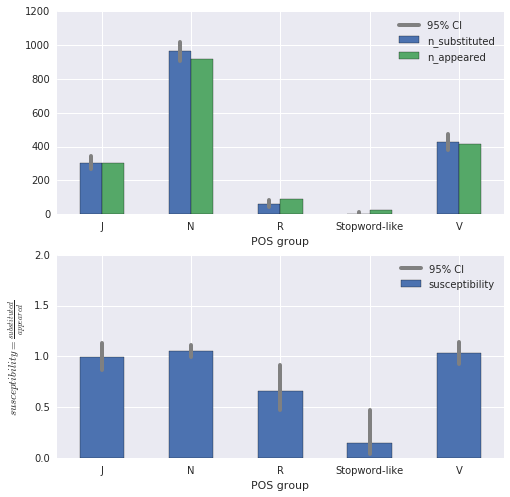

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.001)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


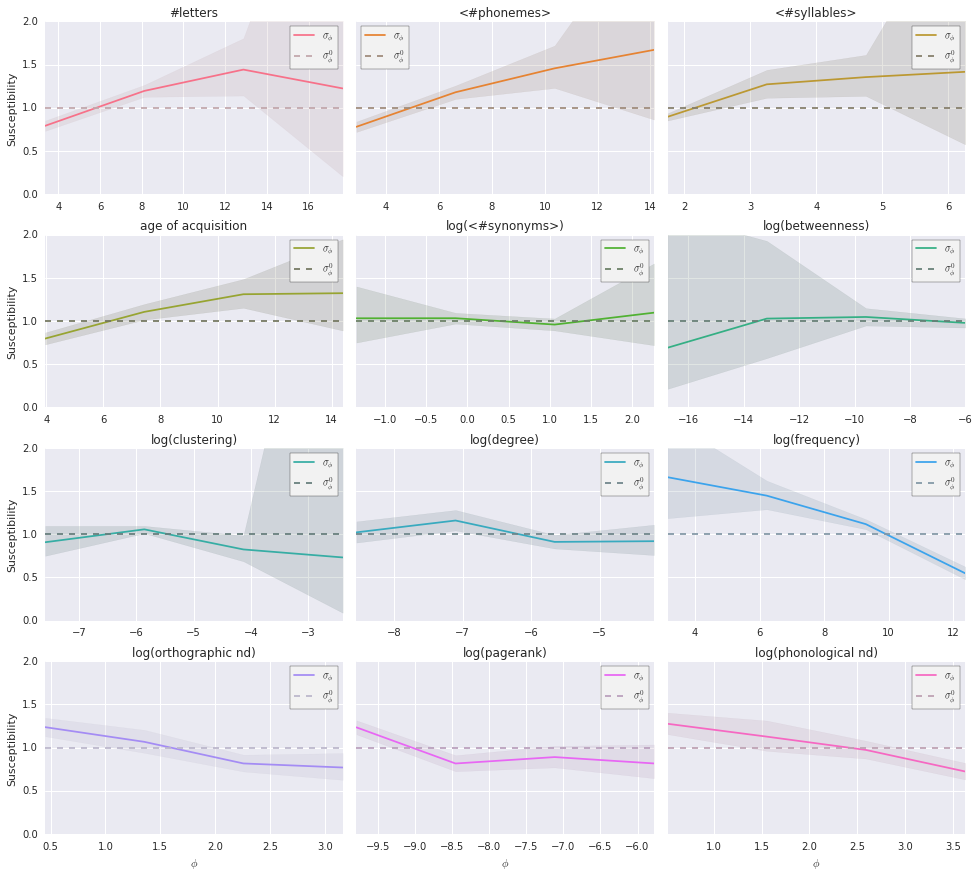

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


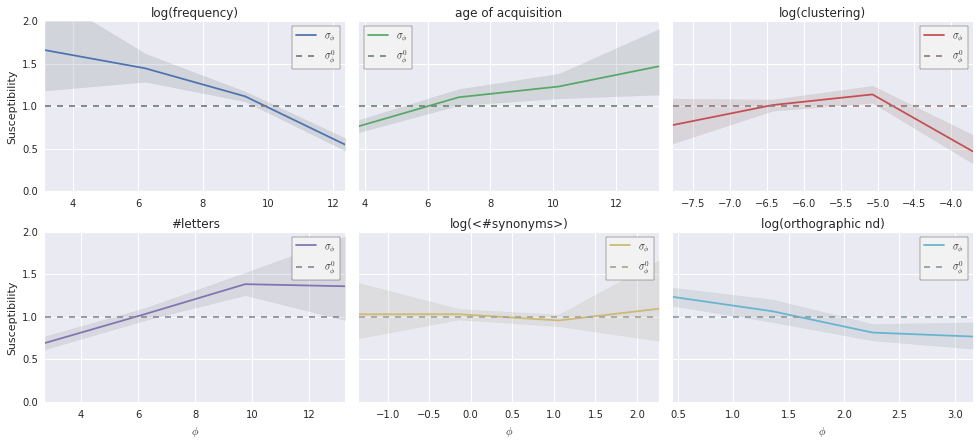

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3, 4]



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


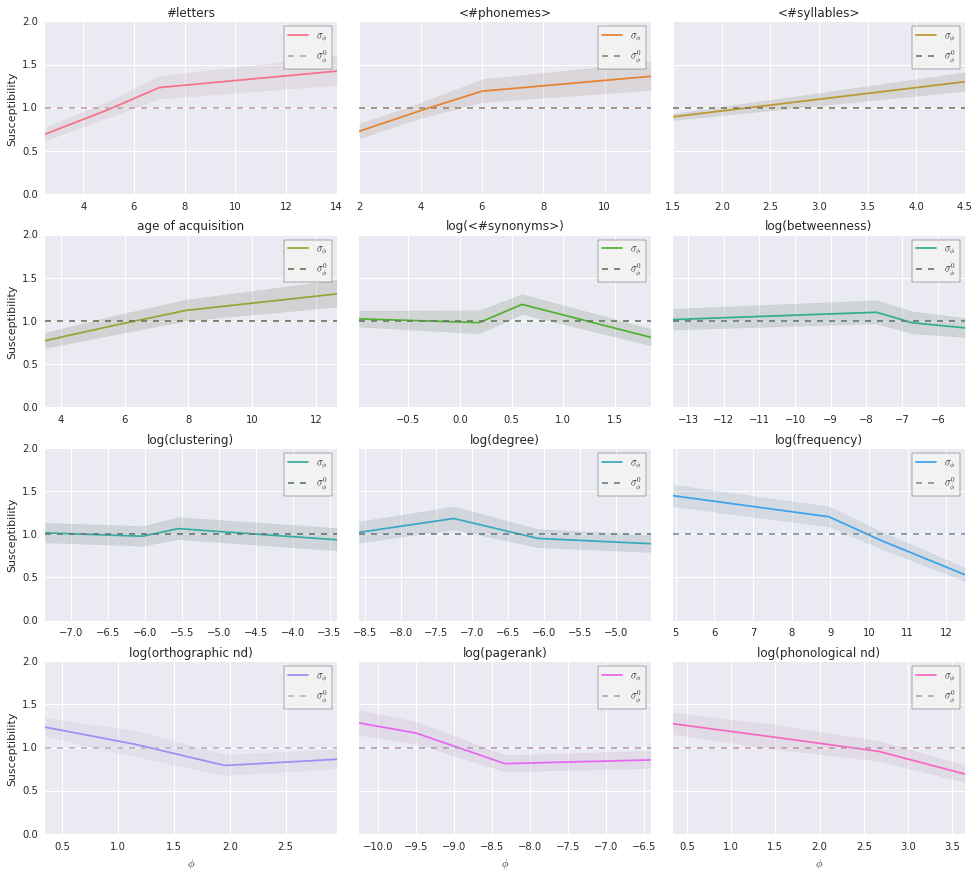

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


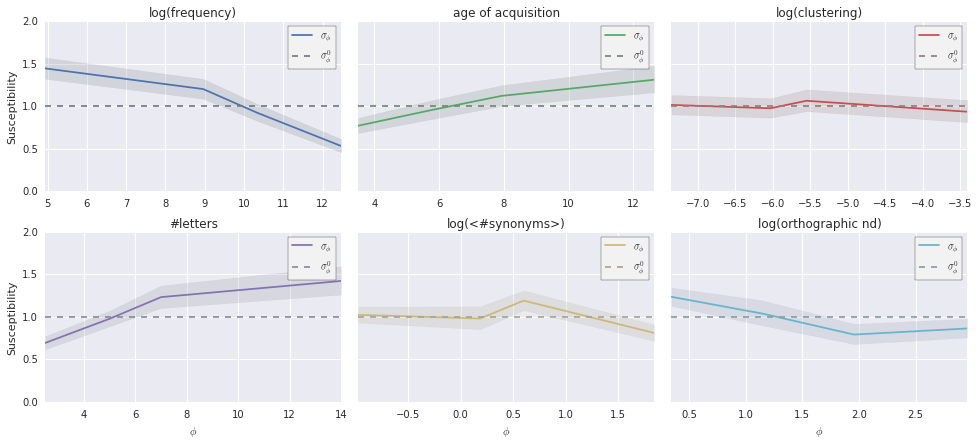

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


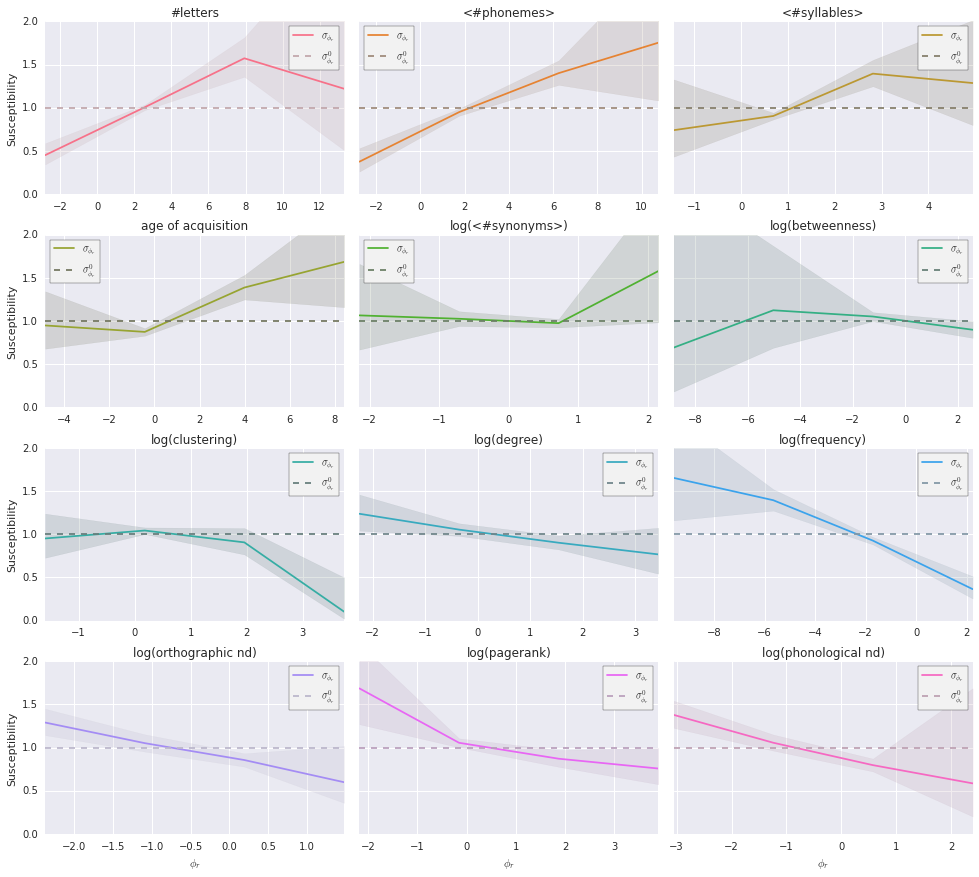

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


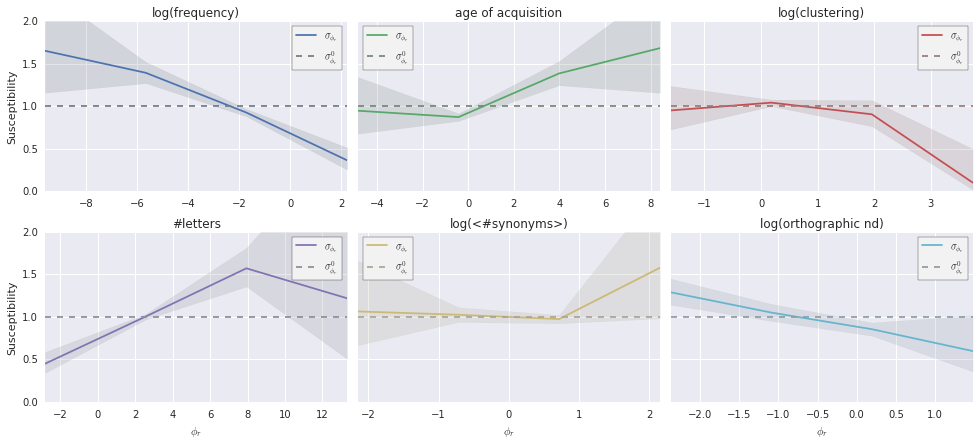

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


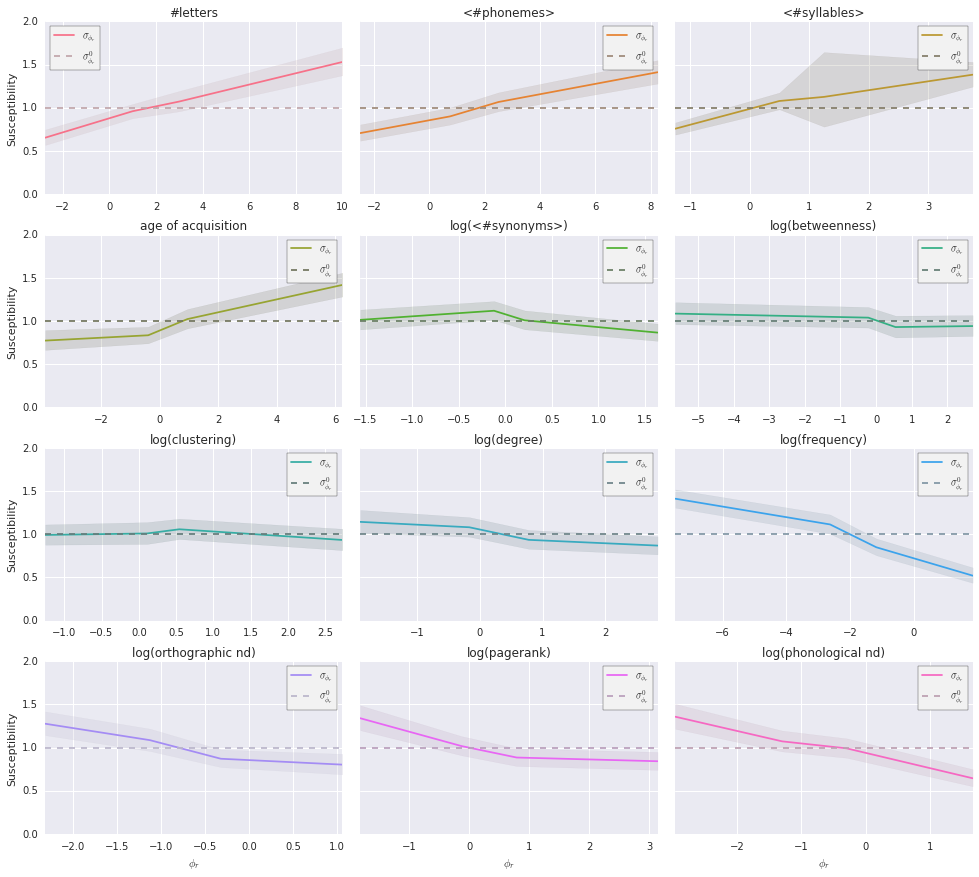

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


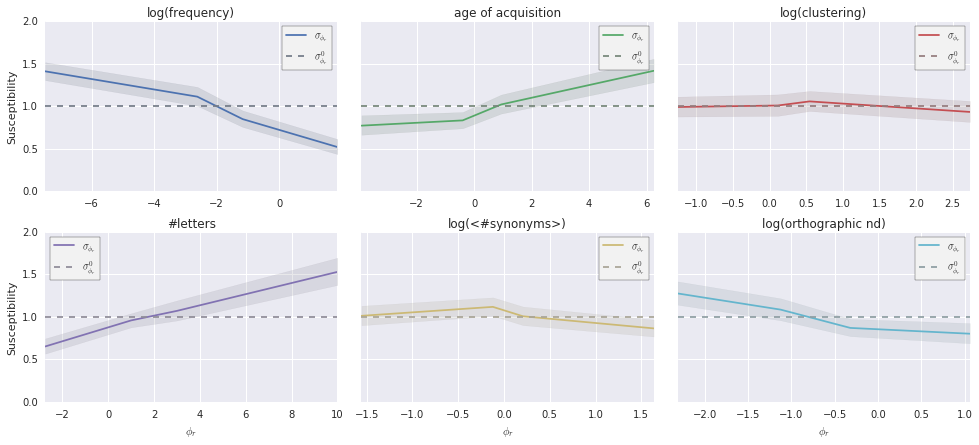

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


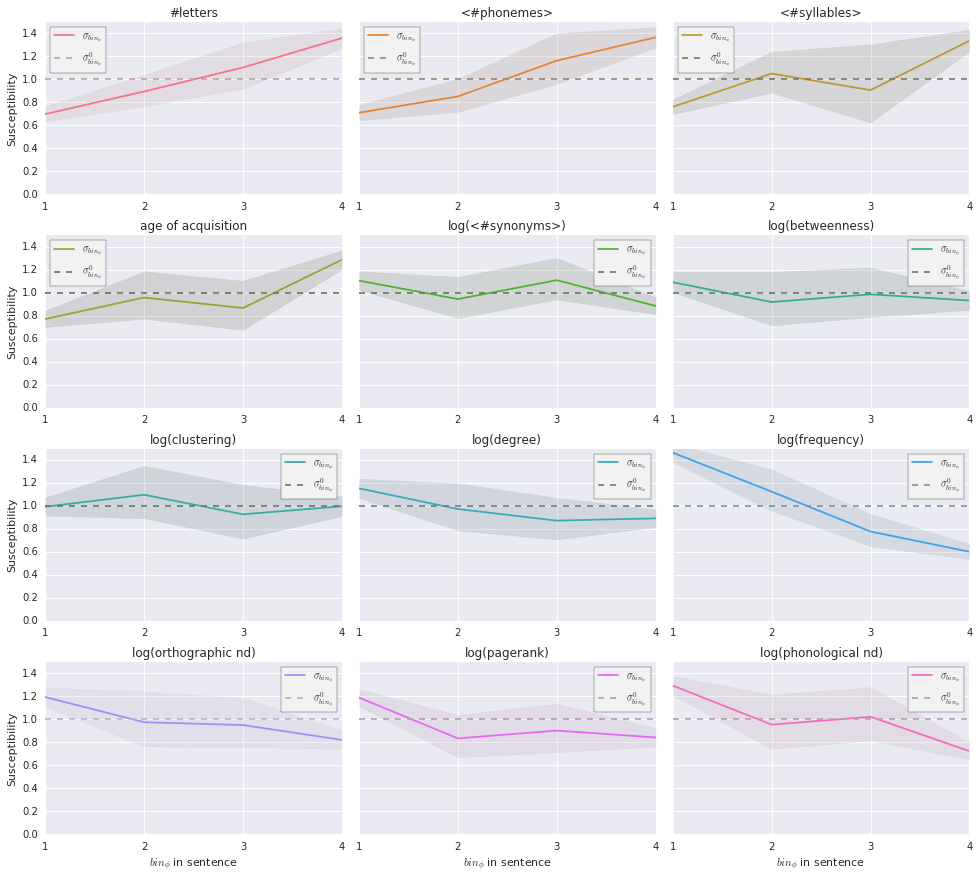

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


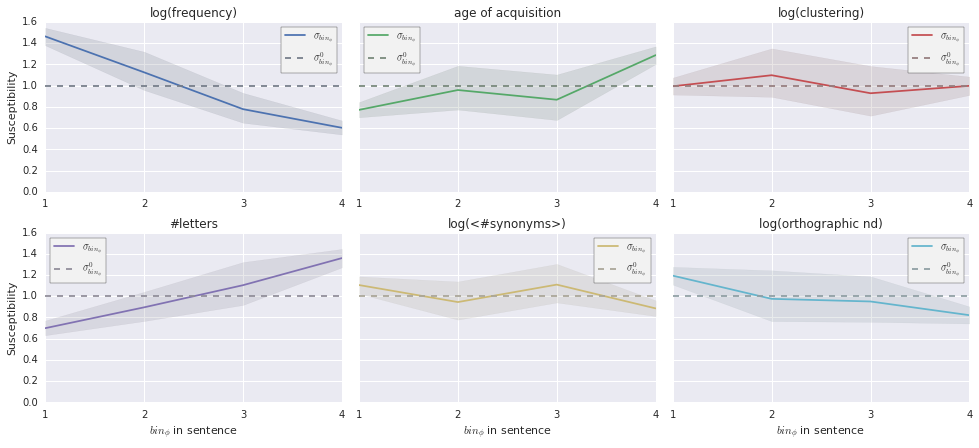

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


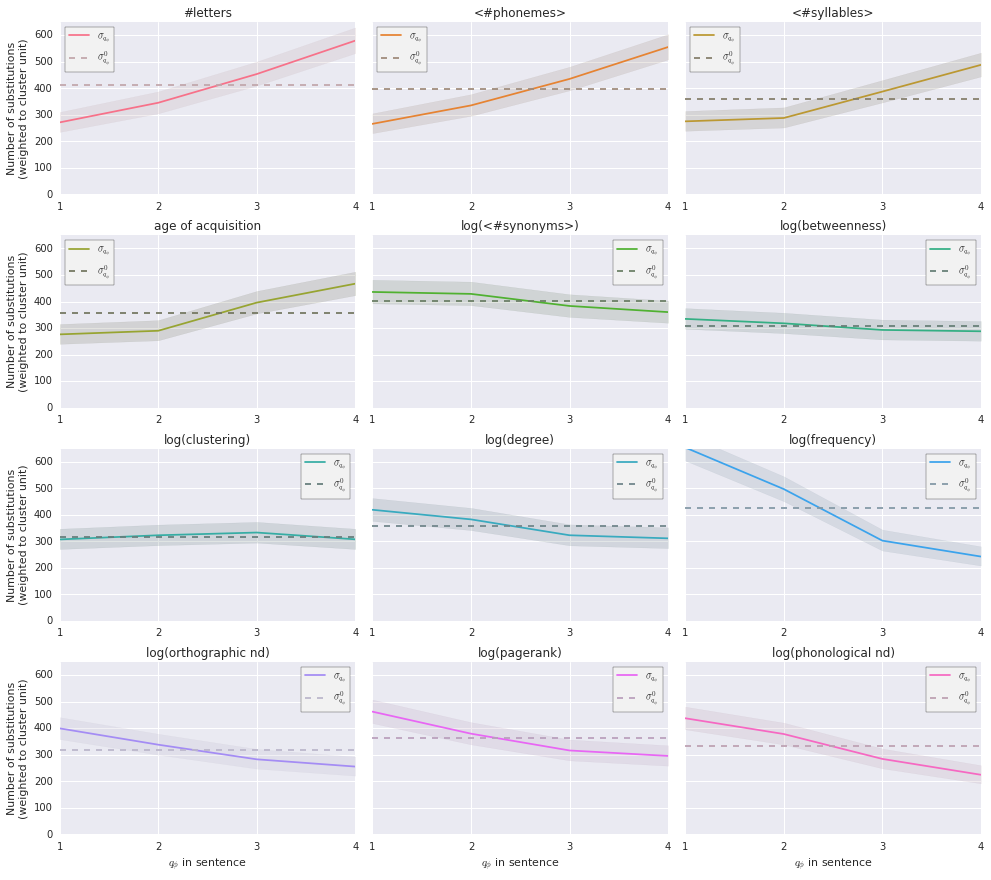

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


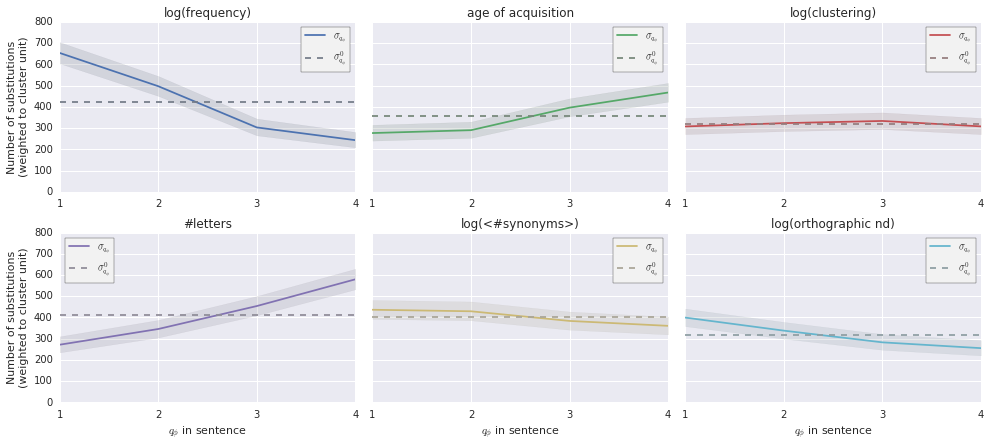

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 50389 word measures (divided into training and prediction sets)



55.00% of words well predicted (non-random at p = 9e-57)
Precision = 0.34
Recall = 0.44

Coefficients:
intercept                                             7.389372
global_frequency                                     -0.208822
global_aoa                                           -1.067494
global_letters_count                                 -0.204911
global_orthographic_density                          -1.317762
global_frequency * global_aoa                         0.040738
global_frequency * global_letters_count              -0.042057
global_frequency * global_orthographic_density        0.042971
global_aoa * global_letters_count                     0.076068
global_aoa * global_orthographic_density              0.148586
global_letters_count * global_orthographic_density   -0.065321
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 50389 word measures (divided into training and prediction sets)

61.05% of words well predicted (non-random at p = 9e-272)
Precision = 0.41
Recall = 0.50

Coefficients:
intercept                                                        -0.217575
sentence-rel_frequency                                           -0.115412
sentence-rel_aoa                                                 -0.059394
sentence-rel_letters_count                                       -0.106035
sentence-rel_orthographic_density                                 0.209529
sentence-rel_frequency * sentence-rel_aoa                        -0.003953
sentence-rel_frequency * sentence-rel_letters_count               0.029970
sentence-rel_frequency * sentence-rel_orthographic_density        0.131618
sentence-rel_aoa * sentence-rel_letters_count                     0.073312
sentence-rel_aoa * sentence-rel_orthographic_density              0.122941
sentence-rel_letters_count * sentence-rel_orthographic_density   

**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 50389 word measures (divided into training and prediction sets)



58.93% of words well predicted (non-random at p = 1e-177)
Precision = 0.40
Recall = 0.57

Coefficients:
intercept                                                         -0.162090
global_frequency                                                   0.653614
global_aoa                                                        -1.772052
global_letters_count                                               1.018578
global_orthographic_density                                       -0.418255
sentence-rel_frequency                                            -1.272386
sentence-rel_aoa                                                  -1.163152
sentence-rel_letters_count                                        -0.224243
sentence-rel_orthographic_density                                  2.175291
global_frequency * global_aoa                                      0.074162
global_frequency * global_letters_count                           -0.198662
global_frequency * global_orthographic_density             

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 50389 word measures (divided into training and prediction sets)



56.10% of words well predicted (non-random at p = 1e-83)
Precision = 0.34
Recall = 0.39

Coefficients:
intercept                                                      -0.935536
bins-global_frequency                                          -0.891435
bins-global_aoa                                                 1.688952
bins-global_letters_count                                      -0.677944
bins-global_orthographic_density                               -1.204658
bins-global_frequency * bins-global_aoa                         0.042951
bins-global_frequency * bins-global_letters_count               0.603385
bins-global_frequency * bins-global_orthographic_density       -0.361196
bins-global_aoa * bins-global_letters_count                    -0.519354
bins-global_aoa * bins-global_orthographic_density             -0.480644
bins-global_letters_count * bins-global_orthographic_density    1.514445
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 50389 word measures (divided into training and prediction sets)



57.05% of words well predicted (non-random at p = 4e-111)
Precision = 0.39
Recall = 0.64

Coefficients:
intercept                                                                 0.917452
quantiles-global_frequency                                                2.590172
quantiles-global_aoa                                                     -1.335146
quantiles-global_letters_count                                           -1.284436
quantiles-global_orthographic_density                                    -2.732333
quantiles-global_frequency * quantiles-global_aoa                        -0.724517
quantiles-global_frequency * quantiles-global_letters_count              -0.455992
quantiles-global_frequency * quantiles-global_orthographic_density        0.529763
quantiles-global_aoa * quantiles-global_letters_count                     1.087611
quantiles-global_aoa * quantiles-global_orthographic_density              0.683554
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 50389 word measures (divided into training and prediction sets)

66.87% of words well predicted (non-random at p = 5e-324)
Precision = 0.46
Recall = 0.26

Coefficients:
intercept                                                                   0.393215
bins-sentence-rel_frequency                                                -0.169035
bins-sentence-rel_aoa                                                      -0.201812
bins-sentence-rel_letters_count                                            -0.111466
bins-sentence-rel_orthographic_density                                      0.393215
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.046530
bins-sentence-rel_frequency * bins-sentence-rel_letters_count              -0.143662
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.169035
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.303465
bins-sentence-rel_aoa * bins-sentence-rel_orthogra

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 50389 word measures (divided into training and prediction sets)



61.24% of words well predicted (non-random at p = 5e-281)
Precision = 0.43
Recall = 0.66

Coefficients:
intercept                                                                             1.965083
quantiles-sentence-rel_frequency                                                     -0.363037
quantiles-sentence-rel_aoa                                                           -0.899867
quantiles-sentence-rel_letters_count                                                 -0.737422
quantiles-sentence-rel_orthographic_density                                          -0.862312
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                        -0.035381
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.078420
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.205571
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters_count                     0.358824
quantiles-sentence-rel_aoa * quantiles-s

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 50389 word measures (divided into training and prediction sets)

60.13% of words well predicted (non-random at p = 2e-228)
Precision = 0.41
Recall = 0.59

Coefficients:
intercept                                                                 0.226752
in-sentence-bins_frequency                                               -0.198102
in-sentence-bins_aoa                                                     -0.014783
in-sentence-bins_letters_count                                            0.015875
in-sentence-bins_orthographic_density                                     0.050028
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.017189
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.025807
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.007052
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.050006
in-sentence-bins_aoa * in-sentence-bins_orthographic_density        

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 1392 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.70466456  0.1672021 ]

Components:
                Comp. 0   Comp. 1
feature                          
frequency      0.355007 -0.530668
aoa           -0.733433  0.352404
letters_count -0.579695 -0.770845


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 1392 aggregated word measures

Variance explained by first 1 components (mle-estimated): [ 0.63546915]

Components:
                Comp. 0
feature                
frequency      0.456550
aoa           -0.638959
letters_count -0.619107
